<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/shap_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

url = 'https://drive.google.com/u/1/uc?id=1cynHrFlPAF594a0UB2bHB1WmObyptZY0&export=download&confirm=t'
output = "Alzheimer.zip"
gdown.download(url, output)

file_path = "Alzheimer.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/1/uc?id=1cynHrFlPAF594a0UB2bHB1WmObyptZY0&export=download&confirm=t
To: /content/Alzheimer.zip
100%|██████████| 300M/300M [00:02<00:00, 140MB/s]


In [2]:
#這邊要記得案y確定移除安裝，最後會有紅色警告 意思是要到 執行階段->重新啟動執行階段 就可以繼續跑第三個block了
!pip install shap
!pip install lime
!pip install efficientnet_pytorch
!pip uninstall imgaug
!pip uninstall matplotlib
!pip install matplotlib==3.5.1

     |████████████████████████████████| 564 kB 3.0 MB/s 
     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=afb00e5033a736b0f7ca42b2fc479420c4a09bb3705bfe9f0554689aaff6ddca
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b33ef0c18daf3221c5f3f96b1831157930e9ca04a5711eb863bc3d5aeadcbff6
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9
Found existing inst

In [1]:
from trainer import trainer
import shap
from skimage.segmentation import mark_boundaries
from Confusion_Matrix import show_confusion_matrix
from loss_fn import *
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from transform import *
import torch.nn as nn
from utils_tool import *
import torch.optim as optim
from Show_Image import Show_Many_Image, Lime_Init

In [2]:
lr = 0.0005  #學習率
resume = True  #是否使用預訓練資料
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
num_worker = 4
epoch = 500
batch_size = 50
momentum = 0.9
train_path = 'Alzheimer/train/'
test_path = 'Alzheimer/test/'

In [3]:
#模型訓練定義
train_ds, test_ds, idx_to_class = get_dataloader(train_path, test_path, batch_size, num_worker)
class_to_id = {v: k for k, v in idx_to_class.items()}
class_names = ['MildDemented', 'NonDemented', 'VeryMildDemented']
print(idx_to_class)
model = EfficientNet.from_pretrained('efficientnet-b2').to(device)
num_feature = model._fc.in_features
model.fc = nn.Linear(num_feature, 3).to(device)
model._fc = nn.Linear(num_feature, 3).to(device)

if resume:
    print('==> Resuming from checkpoint..')
    checkpoint = torch.load('checkpoint/ckpt_0.891081.pth')
    model.load_state_dict(checkpoint['net'])

optimizer = torch.optim.Adam(params=model.parameters(),lr=lr,betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
criterion = nn.CrossEntropyLoss()

train = trainer(train_ds,test_ds, model, optimizer, scheduler, criterion, epoch, best_acc)
train.vaild_scaler_epoch(0)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


{0: 'MildDemented', 1: 'NonDemented', 2: 'VeryMildDemented'}


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2
==> Resuming from checkpoint..


Epoch 1: 100%|██████████| 26/26 [00:08<00:00,  2.89it/s, Acc=0.891, loss=0.699]


Epoch : 1, Val_loss : 0.4662367105484009, Acc : 0.8910812943962115
Saving..


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
100%|██████████| 26/26 [00:07<00:00,  3.34it/s]


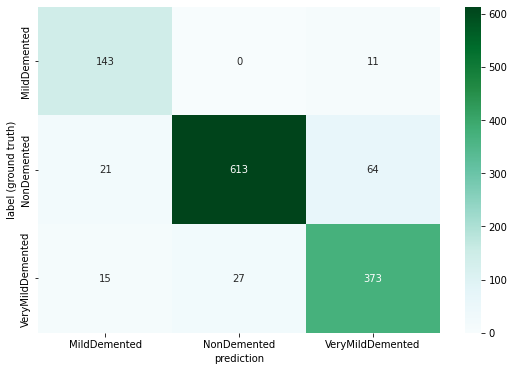

In [4]:
#混淆矩陣
transfer = get_test_transforms()
y_pred, y_true, cofusion_dict = save_image_path_lab_pred(model, test_path, class_to_id, transfer, batch_size, num_worker)
show_confusion_matrix(test_ds, model, class_names, y_pred, y_true)

  0%|          | 0/300 [00:00<?, ?it/s]

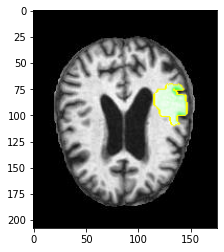

In [6]:
#lime解釋 label MildDemented pred MildDemented
image_visable = Show_Many_Image(model, cofusion_dict, class_to_id=class_to_id, image_shape=(208, 178,3))
image, class_name, pred_name = image_visable.get_image('MildDemented', 'MildDemented')
explain = Lime_Init(model, get_test_transforms())
exp = explain.lime_default(image, top_label=1)
img = explain.lime_explain(exp, label=0)
plt.imshow(img)

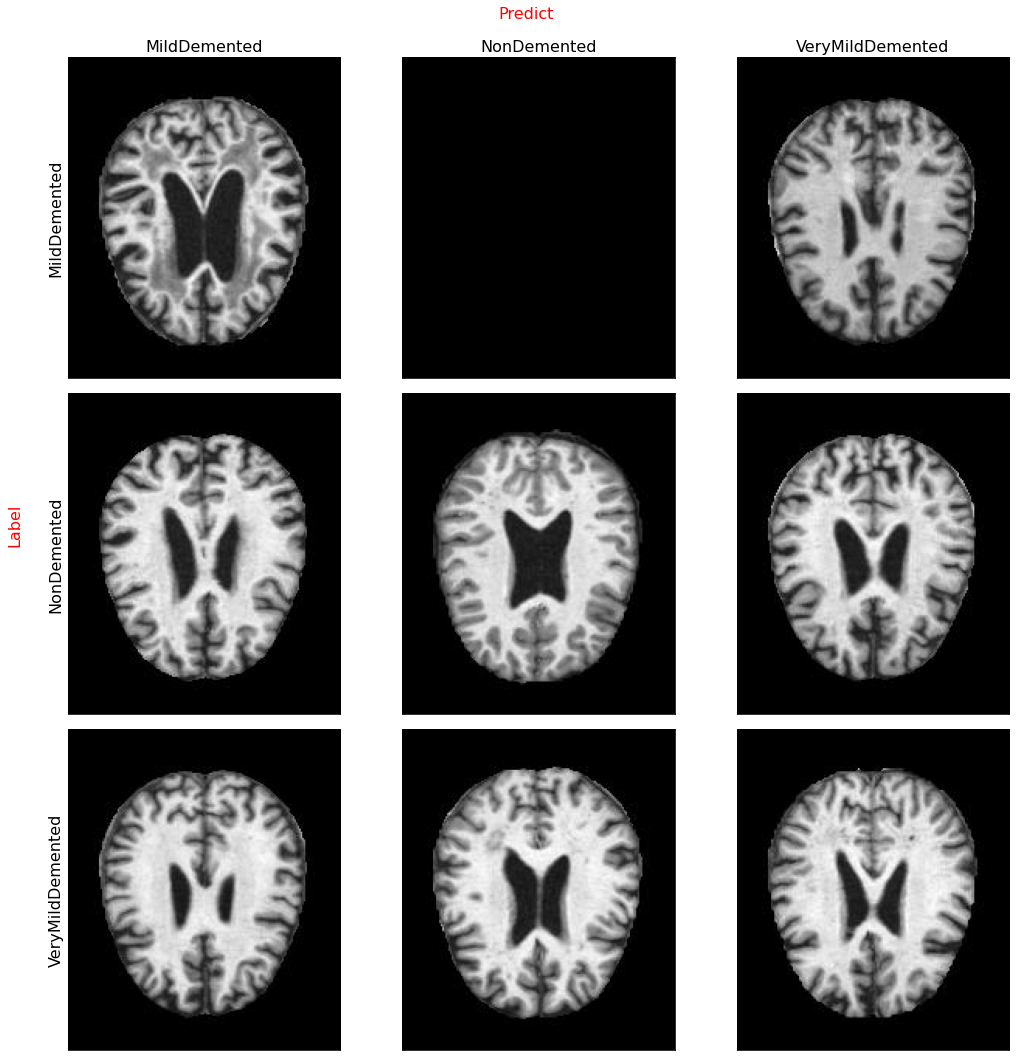

In [7]:
#顯示正確與錯誤的影像
image_visable = Show_Many_Image(model, cofusion_dict, (208, 176, 3), class_to_id)
image_list = image_visable.get_image_matrix()
image_visable.show_image(image_list,title=True)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

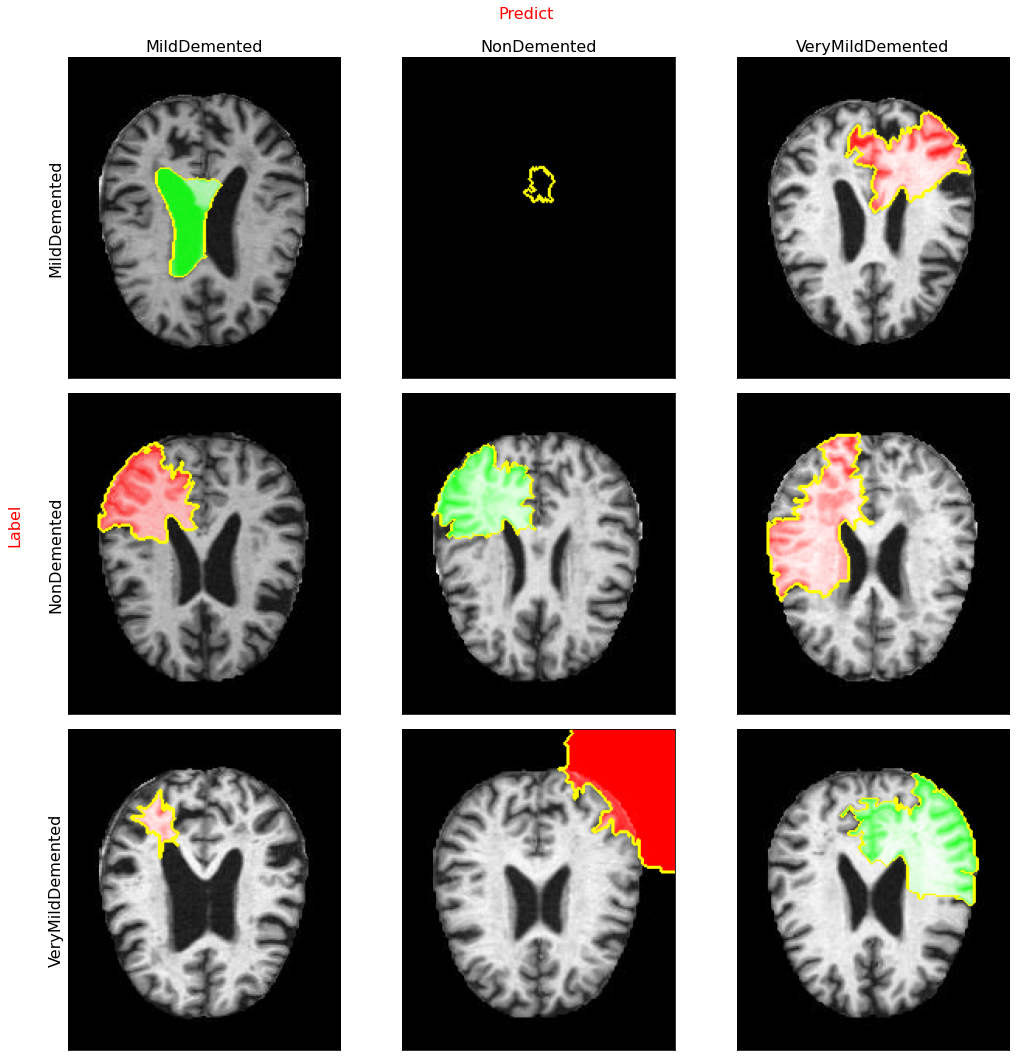

In [8]:
# 解釋類別標籤最大區域
image_list = image_visable.get_image_matrix()
explain = Lime_Init(model, get_test_transforms())
for i in range(len(image_list)):
    data = image_list[i]
    exp = explain.lime_default(np.array(data[0]), top_label=3)
    img = explain.lime_explain(exp, data[1])
    image_list[i][0] = img
image_visable.show_image(image_list)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

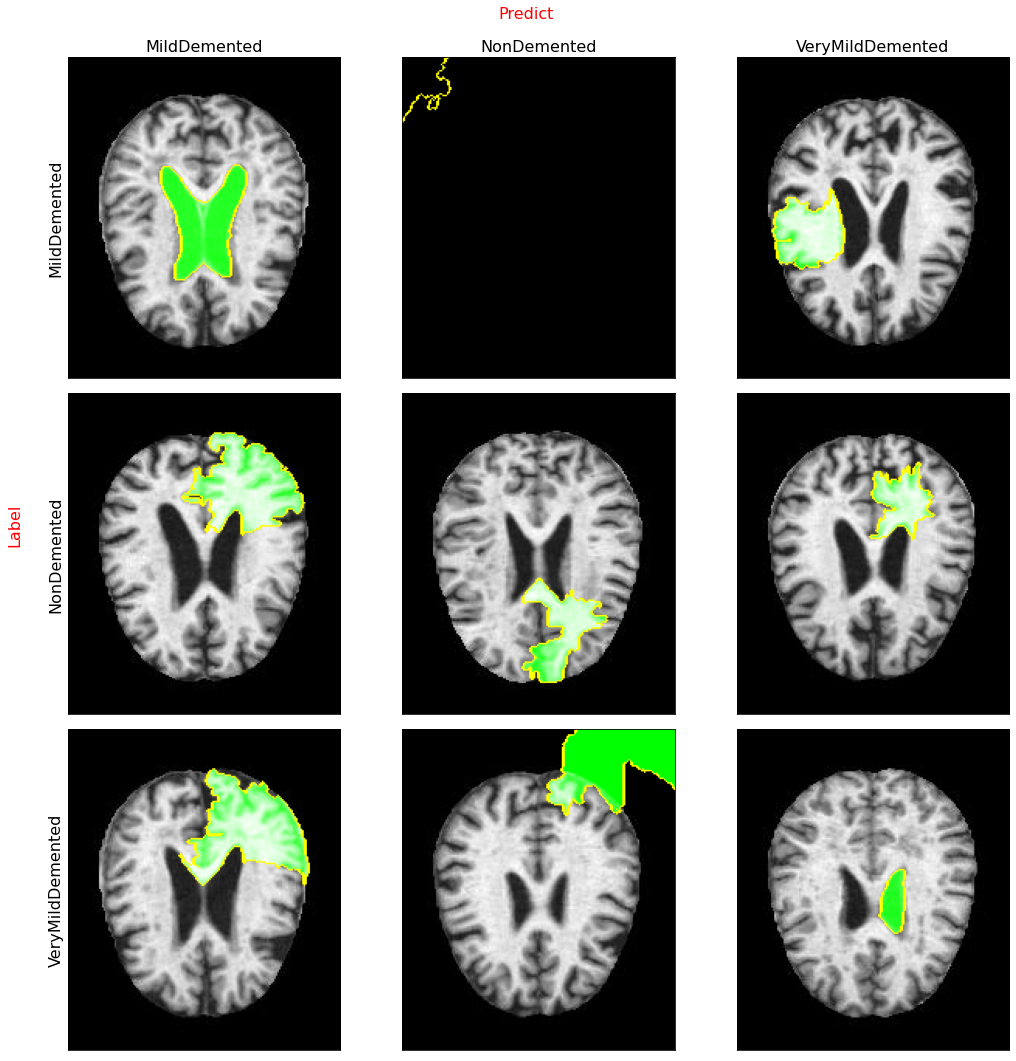

In [9]:
# 解釋預測標籤最大區域
image_list = image_visable.get_image_matrix()
explain = Lime_Init(model, get_test_transforms())
for i in range(len(image_list)):
    data = image_list[i]
    exp = explain.lime_default(np.array(data[0]), top_label=3)
    img = explain.lime_explain(exp, data[2])
    image_list[i][0] = img
image_visable.show_image(image_list)

In [10]:
class HiddenPrints: #隱藏print
  def __init__(self, activated=True):
      self.activated = activated
      self.original_stdout = None

  def open(self):
      sys.stdout.close()
      sys.stdout = self.original_stdout

  def close(self):
      self.original_stdout = sys.stdout
      sys.stdout = open(os.devnull, 'w')

  def __enter__(self):
      if self.activated:
          self.close()

  def __exit__(self, exc_type, exc_val, exc_tb):
      if self.activated:
          self.open()

label: MildDemented, pred: MildDemented


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

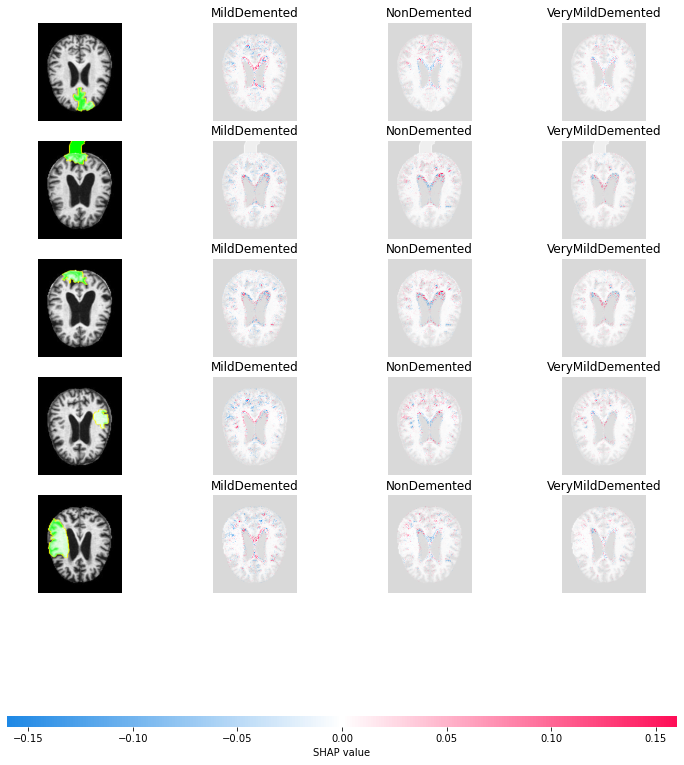

In [12]:
import warnings
import sys
warnings.filterwarnings('ignore')
p = HiddenPrints()
print('label: MildDemented, pred: MildDemented')
p.close()
image_list = []
index_lab = []
index_pred = []
explain_list = []

for i in range(5):
  image, lab_name, pred_name = image_visable.get_image(idx_to_class[0], idx_to_class[0])

  exp = explain.lime_default(image, top_label=3)
  explain_list.append(explain.lime_explain(exp, 0))
  image_list.append(transfer(image))
  index_lab.append(lab_name)
  index_pred.append(pred_name)

explain_list = np.stack(explain_list)
image_list = torch.stack(image_list)
index_lab = np.array([np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names)])
index_pred = np.array(index_pred)


background = image_list.to(device)
e = shap.DeepExplainer(model, background)
n_test_images = 5
shap_values = e.shap_values(background, )
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]


shap.image_plot(shap_numpy, explain_list, index_lab)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

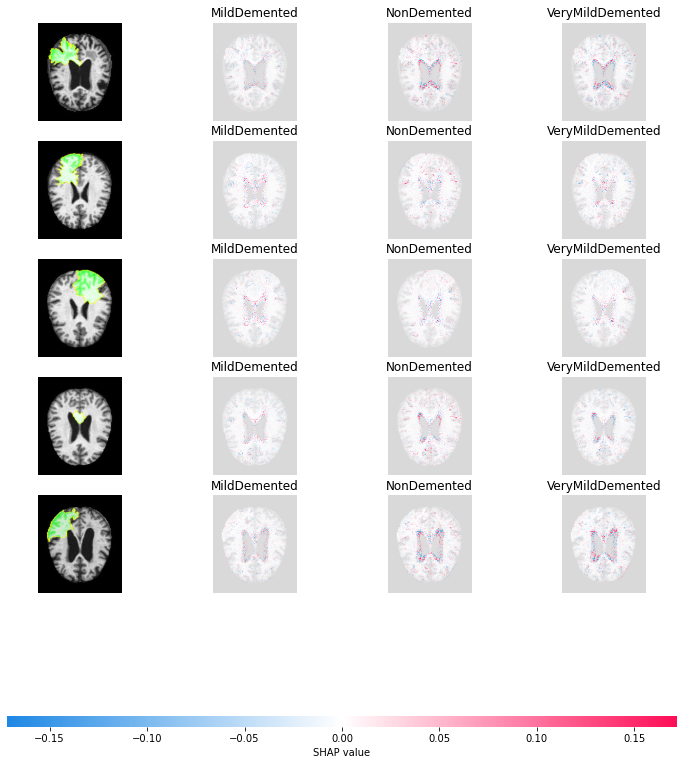

In [13]:
image_list = []
index_lab = []
index_pred = []
explain_list = []

p.open()
print('label: NonDemented, pred: NonDemented')
p.close()
for i in range(5):
  image, lab_name, pred_name = image_visable.get_image(idx_to_class[1], idx_to_class[1])

  exp = explain.lime_default(image, top_label=3)
  explain_list.append(explain.lime_explain(exp, 1))
  image_list.append(transfer(image))
  index_lab.append(lab_name)
  index_pred.append(pred_name)

explain_list = np.stack(explain_list)
image_list = torch.stack(image_list)
index_lab = np.array([np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names)])
index_pred = np.array(index_pred)


background = image_list.to(device)
e = shap.DeepExplainer(model, background)
n_test_images = 5
shap_values = e.shap_values(background)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]


shap.image_plot(shap_numpy, explain_list, index_lab)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

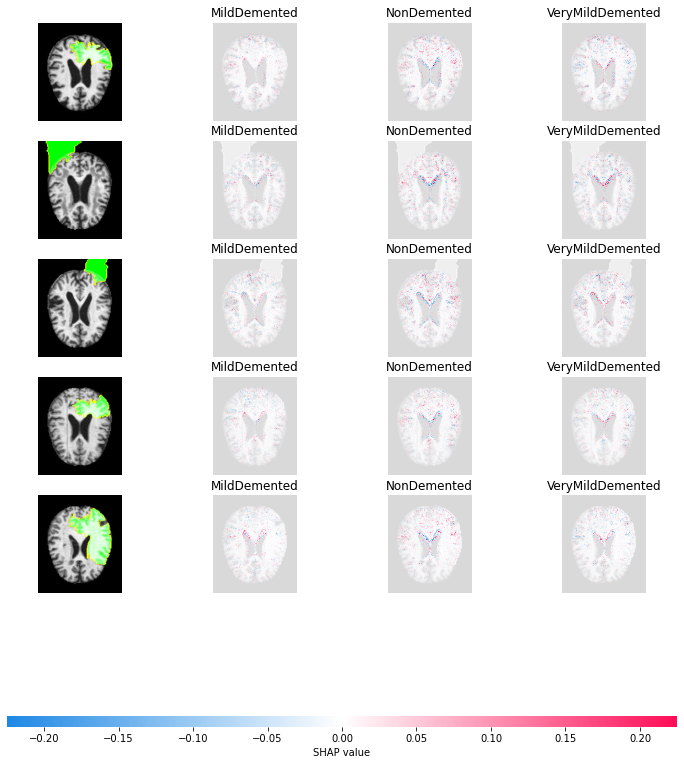

In [14]:
image_list = []
index_lab = []
index_pred = []
explain_list = []

p.open()
print('label: VeryMildDemented, pred: VeryMildDemented')
p.close()

for i in range(5):
  image, lab_name, pred_name = image_visable.get_image(idx_to_class[2], idx_to_class[2])

  exp = explain.lime_default(image, top_label=3)
  explain_list.append(explain.lime_explain(exp, 2))
  image_list.append(transfer(image))
  index_lab.append(lab_name)
  index_pred.append(pred_name)

explain_list = np.stack(explain_list)
image_list = torch.stack(image_list)
index_lab = np.array([np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names),np.array(class_names)])
index_pred = np.array(index_pred)


background = image_list.to(device)
e = shap.DeepExplainer(model, background)
n_test_images = 5
shap_values = e.shap_values(background)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]


shap.image_plot(shap_numpy, explain_list, index_lab)